<a href="https://colab.research.google.com/github/amara929/amara929/blob/main/vivian_ingaitsa_sarima_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from sklearn.preprocessing import LabelEncoder

In [ ]:
warnings.filterwarnings("ignore")

# Load Climate Dataset
data = pd.read_csv('/content/kenya-climate-data-1991-2016-temp-degress-celcius.csv', parse_dates=['Year'], index_col='Year')
print("Dataset Loaded:")
print(data.head())

Dataset Loaded:
           Month Average  Temperature - (Celsius)
Year                                             
1991-01-01   Jan Average                  25.1631
1991-01-01   Feb Average                  26.0839
1991-01-01   Mar Average                  26.2236
1991-01-01   Apr Average                  25.5812
1991-01-01   May Average                  24.6618


In [ ]:
print(data.head())

           Month Average  Temperature - (Celsius)
Year                                             
1991-01-01   Jan Average                  25.1631
1991-01-01   Feb Average                  26.0839
1991-01-01   Mar Average                  26.2236
1991-01-01   Apr Average                  25.5812
1991-01-01   May Average                  24.6618


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 312 entries, 1991-01-01 to 2016-01-01
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month Average            312 non-null    object 
 1   Temperature - (Celsius)  312 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.3+ KB
None


In [ ]:
print("Missing values detected. Replacing with mean...")
    # Check for Missing Values & Replace with Mean
if data.isnull().sum().any():
    data.fillna(data.mean(), inplace=True)

Missing values detected. Replacing with mean...


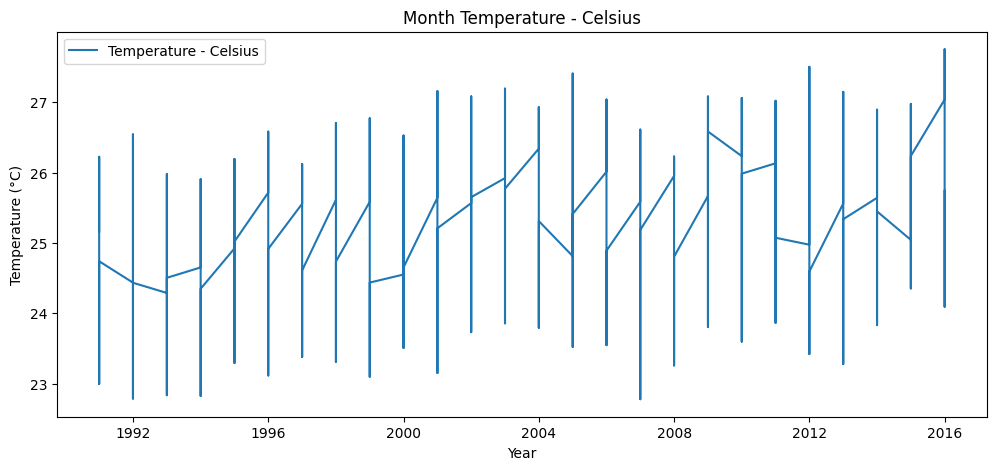

In [ ]:
# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
# Assuming 'Temperature - (Celsius)' is the column you want to plot
plt.plot(data.index, data['Temperature - (Celsius)'], label='Temperature - Celsius')
plt.legend()
plt.title('Month Temperature - Celsius')
plt.xlabel("Year")  # Adding x-axis label
plt.ylabel("Temperature (°C)")  # Adding y-axis label
plt.show()

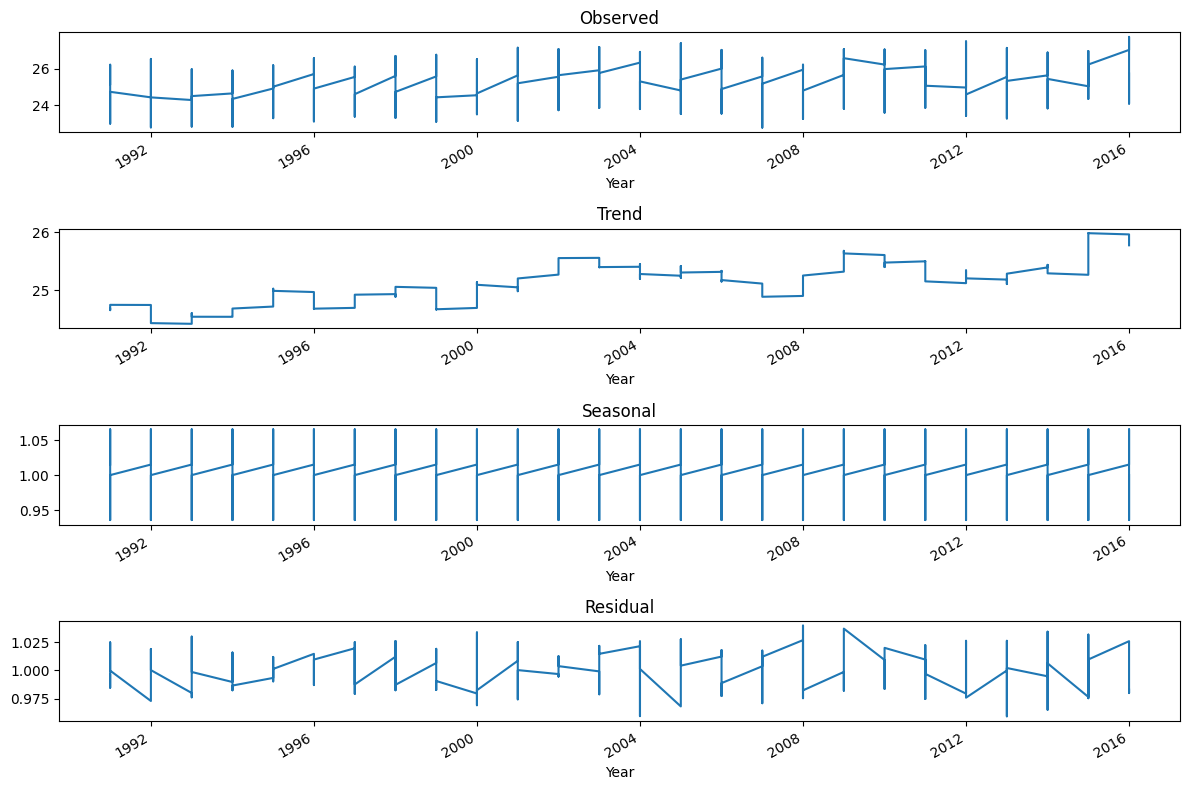

<Figure size 640x480 with 0 Axes>

In [ ]:
# Time Series Decomposition
decomposition = seasonal_decompose(data['Temperature - (Celsius)'], model='multiplicative', period=12)
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

In [ ]:
# Checking Stationarity & Transforming Data
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] <= 0.05

In [ ]:
# Log Transformation to Stabilize Variance
data_log = np.log(data['Temperature - (Celsius)'], )
if not check_stationarity(data_log):
    print("Data is not stationary after log transformation, applying first-order differencing...")
    data_diff = data_log.diff().

dropna()
    if not check_stationarity(data_diff):
        print("Data is still not stationary, applying second-order differencing...")
        data_diff = data_diff.diff().dropna()
else:
    data_diff = data_log

ADF Statistic: -1.8400333285819328
p-value: 0.3607750774069307
Critical Values:
   1%: -3.4525611751768914
   5%: -2.87132117782556
   10%: -2.5719816428028888
Data is not stationary after log transformation, applying first-order differencing...
ADF Statistic: -11.733263983379842
p-value: 1.3260763372970614e-21
Critical Values:
   1%: -3.4524113009049935
   5%: -2.8712554127251764
   10%: -2.571946570731871


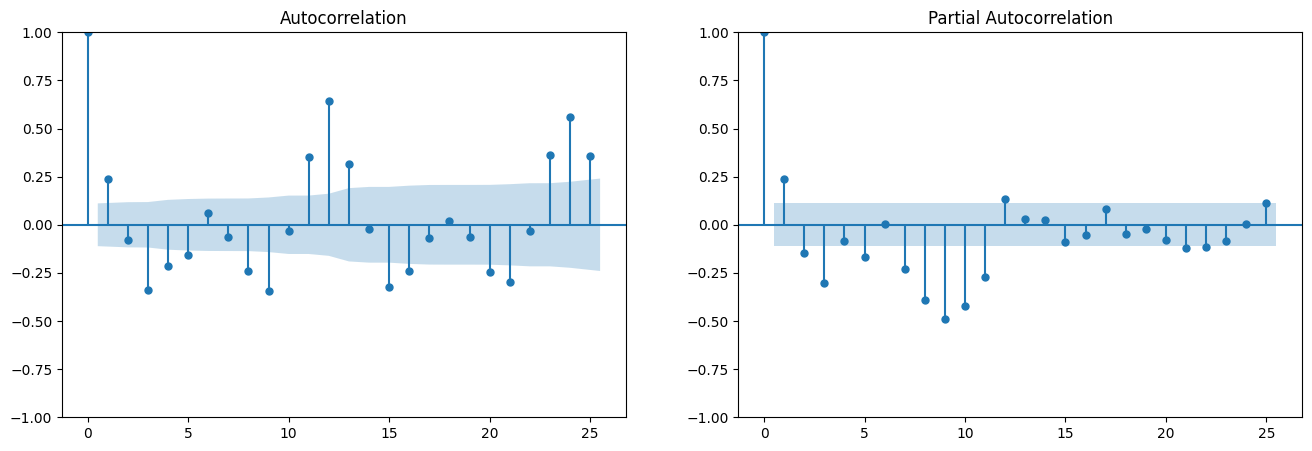

In [ ]:
# Autocorrelation & Partial Autocorrelation Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(data_diff, ax=axes[0])
plot_pacf(data_diff, ax=axes[1])
plt.show()

In [ ]:
# Splitting Data
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [ ]:
# SARIMA Model Training
train_data = train[['Temperature - (Celsius)']]
test_data = test[['Temperature - (Celsius)']]
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:            Temperature - (Celsius)   No. Observations:                  249
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -126.349
Date:                            Mon, 31 Mar 2025   AIC                            262.697
Time:                                    13:24:19   BIC                            280.016
Sample:                                         0   HQIC                           269.679
                                            - 249                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2613      0.074      3.526      0.000       0.116       0.406
ma.L1         -0.9168      0.032   

In [ ]:
# Model Evaluation
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
mae = mean_absolute_error(test['Temperature - (Celsius)'], predictions)
mse = mean_squared_error(test['Temperature - (Celsius)'], predictions)
rmse = np.sqrt(mse)
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

MAE: 0.4353178543980978, MSE: 0.31245245410507705, RMSE: 0.5589744664160224
MAE: 0.4353178543980978, MSE: 0.31245245410507705, RMSE: 0.5589744664160224


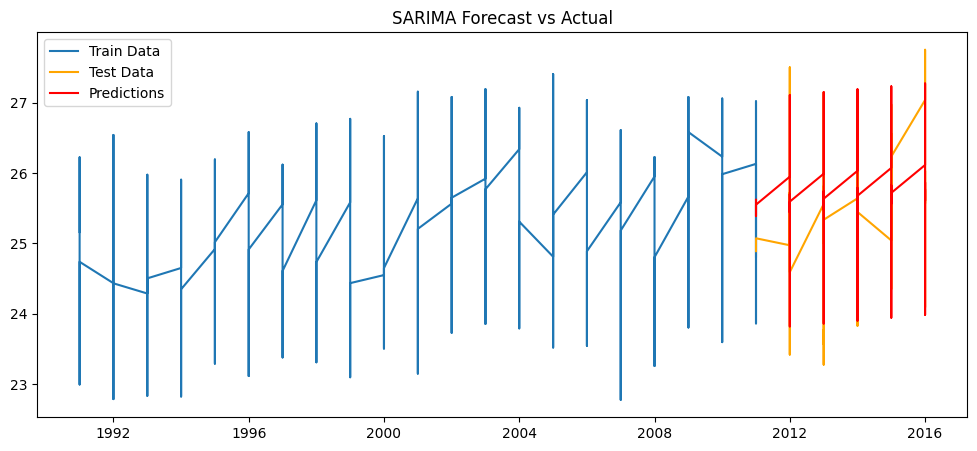

In [ ]:
# Plotting Predictions
plt.figure(figsize=(12, 5))
plt.plot(train.index,train['Temperature - (Celsius)'], label='Train Data')
plt.plot(test.index,test['Temperature - (Celsius)'], label='Test Data', color='orange')
plt.plot(test.index,predictions, label='Predictions', color='red')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.show()

In [ ]:
# Forecasting Future Values
future_steps = 12
forecast = model_fit.forecast(steps=future_steps)
print(f'Forecasted Values:\n{forecast}')

Forecasted Values:
249    25.620721
250    25.388972
251    25.551240
252    25.948614
253    26.713987
254    27.106265
255    26.572201
256    25.571671
257    24.478297
258    23.822669
259    24.275209
260    25.009750
Name: predicted_mean, dtype: float64


In [ ]:
# User Input & Prediction
steps = int(input("Enter the number of future steps to predict: "))
user_forecast = model_fit.forecast(steps=steps)
print(f'Predicted values for next {steps} steps:\n{user_forecast}')

Enter the number of future steps to predict: 25
Predicted values for next 25 steps:
249    25.620721
250    25.388972
251    25.551240
252    25.948614
253    26.713987
254    27.106265
255    26.572201
256    25.571671
257    24.478297
258    23.822669
259    24.275209
260    25.009750
261    25.702342
262    25.441044
263    25.594548
264    25.990303
265    26.756515
266    27.147945
267    26.612732
268    25.612507
269    24.519643
270    23.863872
271    24.317106
272    25.051359
273    25.743755
Name: predicted_mean, dtype: float64


In [ ]:
# User Input & Prediction
steps = int(input("Enter the number of future steps to predict: "))
user_forecast = model_fit.forecast(steps=steps)
print(f'Predicted values for next {steps} steps:\n{user_forecast}')

Enter the number of future steps to predict: 20
Predicted values for next 20 steps:
249    25.620721
250    25.388972
251    25.551240
252    25.948614
253    26.713987
254    27.106265
255    26.572201
256    25.571671
257    24.478297
258    23.822669
259    24.275209
260    25.009750
261    25.702342
262    25.441044
263    25.594548
264    25.990303
265    26.756515
266    27.147945
267    26.612732
268    25.612507
Name: predicted_mean, dtype: float64
